### Oslo Bus Network Robustness

The pipeline:

- Load CSV files.
- Prepare and clean **bus edges**.
- Filter **bus stops** and keep bus edges only.
- Group **all bus stops** into clusters using DBSCAN.
- Build a **directed multigraph** where:
  - nodes = stops,
  - edges = bus trips with weight = travel time (seconds).
- Create two **hubs** combining multiple physical stops:
- OSLO HUB - Oslo S, bus terminal, Jernbanetorget area;
- SKOYEN HUB - Skøyen area.
- Compute the **shortest-time path** between the hubs using Dijkstra.

- **Stop-level experiments**:
  - remove 1 internal stop,
  - remove 2 consecutive internal stops,
  - remove 2 random internal stops (10 runs),
  - remove all internal stops on the base path (whole-path stop failure).

- **Cluster-level experiments**:
  - remove 1 internal cluster (all its stops),
  - remove 2 consecutive internal clusters,
  - remove 2 random internal clusters (10 runs),
  - remove all internal clusters on the base path (whole-path cluster failure).

All routing is done on the **same stop-level MultiDiGraph** with bus edges + walking edges.
Clusters are used both as analysis labels and to define walking connectivity inside stop areas.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.exception import NetworkXNoPath
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import random

### 1 Load data


In [2]:
nodes = pd.read_csv("../../Extraction/out/nodes_GTFS_OSLO.csv")
edges = pd.read_csv("../../Extraction/out/edges_GTFS_OSLO_with_mondayTrips.csv")

nodes.shape, edges.shape

((1941, 7), (4825, 9))

### 2 Filter bus edges and clean `travelTimeSec`

Focus on **bus** edges only (`mode == "bus"`).

Ensure `travelTimeSec` is numeric and fill missing values:

1. Convert with `errors="coerce"` - invalid values become NaN.
2. For each `lineId`, fill NaN with the **median** of that line.
3. If values are still missing, fill with the **global median**.

In [3]:
# 2 Keep bus edges only
bus_edges = edges[edges["mode"] == "bus"].copy()

# 2.1 Ensure travelTimeSec is numeric
bus_edges["travelTimeSec"] = pd.to_numeric(
    bus_edges["travelTimeSec"],
    errors="coerce"
)

# 2.2 Per-line median imputation
bus_edges["travelTimeSec"] = (
    bus_edges
    .groupby("lineId")["travelTimeSec"]
    .transform(lambda x: x.fillna(x.median()))
)

# 2.3 Global median fallback
global_median = bus_edges["travelTimeSec"].median()
bus_edges["travelTimeSec"] = bus_edges["travelTimeSec"].fillna(global_median)

bus_edges["travelTimeSec"].describe()

c:\pr\statistical_lerning\ACIT4620_Exam_Project_Code\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


count    3896.000000
mean       94.751027
std        66.951515
min        60.000000
25%        60.000000
50%        60.000000
75%       120.000000
max       840.000000
Name: travelTimeSec, dtype: float64

### 3 Select bus stops

Keep only:

1. Stops that support bus (their `modes` string contains `"bus"`).
2. Stops that are actually used in bus edges as `from` or `to`.

This guarantees that **no bus stop (quay) used in the bus edge file is lost**.

In [4]:
nodes["modes"] = nodes["modes"].astype(str)
bus_nodes = nodes[nodes["modes"].str.contains("bus")].copy()

used_node_ids = set(bus_edges["from"]) | set(bus_edges["to"])
bus_nodes = bus_nodes[bus_nodes["id"].isin(used_node_ids)].copy()

bus_nodes.shape

(1525, 7)

### 4 DBSCAN clustering of all bus stops

Group **all bus stops** into clusters using DBSCAN:

- Input points: (`lat`, `lon`) of each stop.
- Metric: `haversine`.
- Radius: 100 m.

DBSCAN returns:

- `cluster_raw` ≥ 0 for clustered stops,
- `cluster_raw == -1` for noise (isolated stops).

We then convert each noise point into its own singleton cluster (`cluster_id`),
so that **every stop has a `cluster_id`**.

In [5]:
# 4.1 Coordinates in radians
coords_deg = bus_nodes[["lat", "lon"]].to_numpy()
coords_rad = np.radians(coords_deg)

# 4.2 DBSCAN with haversine metric
eps_km = 0.1  # 100 meters
kms_per_radian = 6371.0088
eps_rad = eps_km / kms_per_radian

db = DBSCAN(
    eps=eps_rad,
    min_samples=2,
    metric="haversine"
)

cluster_labels = db.fit_predict(coords_rad)
bus_nodes["cluster_raw"] = cluster_labels

bus_nodes["cluster_raw"].value_counts().sort_index().head()

cluster_raw
-1    227
 0      4
 1     23
 2      2
 3      2
Name: count, dtype: int64

In [6]:
# 4.3 Convert noise (-1) to singleton clusters
bus_nodes["cluster_id"] = bus_nodes["cluster_raw"].copy()

max_cluster = bus_nodes["cluster_raw"].max()
next_cluster_id = max_cluster + 1 if max_cluster >= 0 else 0

for idx, row in bus_nodes[bus_nodes["cluster_raw"] == -1].iterrows():
    bus_nodes.at[idx, "cluster_id"] = next_cluster_id
    next_cluster_id += 1

n_clusters = bus_nodes["cluster_id"].nunique()
n_clusters

771

### 5 Explore clusters and their stops

Create a summary table to see:

- `cluster_id`,
- number of stops inside each cluster,
- list of distinct stop names.

This helps understand which stops are grouped into which stop area.

In [7]:
cluster_summary = (
    bus_nodes
    .groupby("cluster_id")
    .agg(
        n_stops=("id", "count"),
        stop_names=("name", lambda x: sorted(set(x)))
    )
    .reset_index()
)

cluster_summary.head(15)

,cluster_id,n_stops,stop_names
0,0,4,"[Tjuvholmen, Vika atrium]"
1,1,23,[Oslo bussterminal]
2,2,2,[Filipstadveien]
3,3,2,[Bånkallstubben]
4,4,2,[Rommi]
5,5,2,[Sveiva]
6,6,2,[Romsåsfoten]
7,7,3,[Grorudkrysset]
8,8,2,[Flaen]
9,9,4,"[Linderud senter, Linderudsletta]"


### 6 Build MultiDiGraph

Build the **core graph** `G`:

- **Graph type**: `nx.MultiDiGraph()` to keep all parallel edges.
- **Nodes**:
  - every stop in `bus_nodes`,
  - attributes: `name`, `lat`, `lon`, `stopPlaceId`, `cluster_id`.
- **Edges**:
  - each row of `bus_edges` becomes a separate edge `from → to`,
  - attributes: `weight = travelTimeSec`, `lineId`, `lineCode`, `mode="bus"`, `authority`.

In [8]:
# 6.1 Create MultiDiGraph
G = nx.MultiDiGraph()

# 6.2 Add nodes
for _, row in bus_nodes.iterrows():
    G.add_node(
        row["id"],
        name=row["name"],
        lat=row["lat"],
        lon=row["lon"],
        stopPlaceId=row["stopPlaceId"],
        cluster_id=row["cluster_id"],
    )

# 6.3 Add all bus edges (no aggregation)
for _, row in bus_edges.iterrows():
    u = row["from"]
    v = row["to"]
    t = row["travelTimeSec"]

    if G.has_node(u) and G.has_node(v):
        G.add_edge(
            u,
            v,
            weight=t,
            lineId=row["lineId"],
            lineCode=row["lineCode"],
            mode="bus",
            authority=row["authority"],
        )

G.number_of_nodes(), G.number_of_edges()

(1525, 3896)

### 7 Add fixed 60 second walking edges inside each cluster

- A **cluster** is a group of stops within ~100 m of each other.
- Inside a cluster, we assume a traveler can walk between **any two stops**
  in a fixed **60 seconds**.

So for each `cluster_id`:

- take all stop IDs in that cluster,
- connect every unordered pair of stops with:
  - `u - v` (weight 60, mode "walk"),
  - `v - u` (weight 60, mode "walk").

This creates fully connected walking subgraphs inside each stop area.

In [9]:
# 7.1 Build mapping: cluster_id - list of stop IDs
cluster_to_stops_ids = (
    bus_nodes.groupby("cluster_id")["id"]
    .apply(list)
    .to_dict()
)

walking_time_s = 60  # fixed 60 seconds for any walk within a cluster

# 7.2 Add walking edges inside each cluster
for cid, stop_ids in cluster_to_stops_ids.items():
    if len(stop_ids) < 2:
        continue  # only one stop in this cluster, nothing to connect

    # connect every pair of stops in this cluster
    for i in range(len(stop_ids)):
        for j in range(i + 1, len(stop_ids)):
            u = stop_ids[i]
            v = stop_ids[j]

            if G.has_node(u) and G.has_node(v):
                G.add_edge(u, v, weight=walking_time_s, mode="walk")
                G.add_edge(v, u, weight=walking_time_s, mode="walk")

G.number_of_nodes(), G.number_of_edges()

(1525, 6778)

### 8 Define Oslo and Skøyen hubs

Study routes between two **hub areas**:

- **Oslo hub**:
  - Stops with names `"Oslo bussterminal"` or `"Jernbanetorget"`.

- **Skøyen hub**:
  - Stops with names `"Skøyen"` or `"Skøyen stasjon"`.

These are sets of physical stops which will be connected to abstract hub nodes.

In [10]:
oslo_hub_allowed = ["Oslo bussterminal", "Jernbanetorget"]
oslo_hub_nodes = bus_nodes[bus_nodes["name"].isin(oslo_hub_allowed)].copy()

skoyen_hub_allowed = ["Skøyen", "Skøyen stasjon"]
skoyen_hub_nodes = bus_nodes[bus_nodes["name"].isin(skoyen_hub_allowed)].copy()

oslo_hub_nodes.shape, skoyen_hub_nodes.shape

((35, 9), (6, 9))

### 9 Add hub nodes and transfer edges

Create two nodes:

- `OSLO_HUB`: representing the Oslo central area.
- `SKOYEN_HUB`: representing the Skøyen area.

For each hub:

1. Add the hub node (with mean coordinates of its stops, for reference).
2. Connect:
   - each physical stop - hub,
   - hub - each physical stop,
   with a fixed **60-second transfer time**.

In [11]:
OsloHub = "OSLO_HUB"
SkoyenHub = "SKOYEN_HUB"

oslo_lat = oslo_hub_nodes["lat"].mean()
oslo_lon = oslo_hub_nodes["lon"].mean()
skoyen_lat = skoyen_hub_nodes["lat"].mean()
skoyen_lon = skoyen_hub_nodes["lon"].mean()

G.add_node(
    OsloHub,
    name="Oslo HUB (Oslo bussterminal / Jernbanetorget)",
    lat=oslo_lat,
    lon=oslo_lon,
    stopPlaceId="hub",
    cluster_id=None,
)

G.add_node(
    SkoyenHub,
    name="Skøyen HUB",
    lat=skoyen_lat,
    lon=skoyen_lon,
    stopPlaceId="hub",
    cluster_id=None,
)

transfer_time = 60  # seconds

for nid in oslo_hub_nodes["id"]:
    if G.has_node(nid):
        G.add_edge(nid, OsloHub, weight=transfer_time, mode="transfer")
        G.add_edge(OsloHub, nid, weight=transfer_time, mode="transfer")

for nid in skoyen_hub_nodes["id"]:
    if G.has_node(nid):
        G.add_edge(nid, SkoyenHub, weight=transfer_time, mode="transfer")
        G.add_edge(SkoyenHub, nid, weight=transfer_time, mode="transfer")

G.number_of_nodes(), G.number_of_edges()

(1527, 6860)

### 10 Compute base fastest path OSLO_HUB to SKOYEN_HUB

Compute the **fastest path** in the full graph `G`:

- edges include:
  - bus,
  - walking inside clusters,
  - transfer between hubs and physical stops.

We use Dijkstra with `weight="weight"` (seconds) and convert to minutes.

In [12]:
try:
    base_path = nx.dijkstra_path(G, OsloHub, SkoyenHub, weight="weight")
    base_time_sec = nx.dijkstra_path_length(G, OsloHub, SkoyenHub, weight="weight")
    base_time_min = base_time_sec / 60

    print("BASE FASTEST PATH (with bus + walking + transfer):")
    for nid in base_path:
        print(nid, "-", G.nodes[nid].get("name"))

    print("\nBase travel time (min):", round(base_time_min, 1))
    print("Number of hops (edges):", len(base_path) - 1)

except NetworkXNoPath:
    print("No path between OSLO_HUB and SKOYEN_HUB.")
    base_path = None
    base_time_sec = None
    base_time_min = None

BASE FASTEST PATH (with bus + walking + transfer):
OSLO_HUB - Oslo HUB (Oslo bussterminal / Jernbanetorget)
NSR:Quay:7159 - Jernbanetorget
NSR:Quay:101778 - Kvadraturen
NSR:Quay:101777 - Wessels plass
NSR:Quay:7350 - Nationaltheatret
NSR:Quay:104030 - Solli
NSR:Quay:7813 - Frogner kirke
NSR:Quay:7835 - Olav Kyrres plass
NSR:Quay:11844 - Thune
NSR:Quay:11817 - Skøyen stasjon
SKOYEN_HUB - Skøyen HUB

Base travel time (min): 16.0
Number of hops (edges): 10


In [13]:
if base_path is None:
    raise RuntimeError("No base path found – cannot run experiments.")

internal_nodes = [n for n in base_path if n not in (OsloHub, SkoyenHub)]

print("Internal stops on base path:")
for nid in internal_nodes:
    print(nid, "-", G.nodes[nid].get("name"), "| cluster:", G.nodes[nid].get("cluster_id"))

Internal stops on base path:
NSR:Quay:7159 - Jernbanetorget | cluster: 118
NSR:Quay:101778 - Kvadraturen | cluster: 600
NSR:Quay:101777 - Wessels plass | cluster: 117
NSR:Quay:7350 - Nationaltheatret | cluster: 116
NSR:Quay:104030 - Solli | cluster: 93
NSR:Quay:7813 - Frogner kirke | cluster: 115
NSR:Quay:7835 - Olav Kyrres plass | cluster: 114
NSR:Quay:11844 - Thune | cluster: 250
NSR:Quay:11817 - Skøyen stasjon | cluster: 251


### 11 Visualise clusters and base path

Plot:

- all bus stops colored by `cluster_id`,
- the base path as a line.

This gives an intuitive picture of how the base route traverses stop areas.

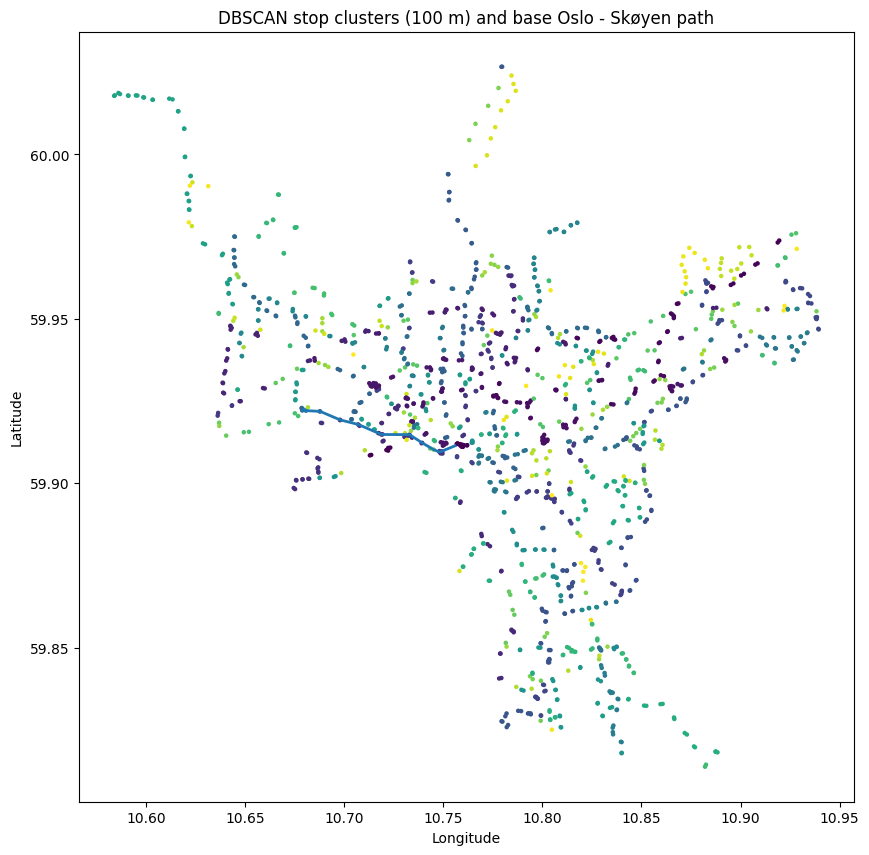

In [14]:
plt.figure(figsize=(10, 10))

plt.scatter(
    bus_nodes["lon"],
    bus_nodes["lat"],
    c=bus_nodes["cluster_id"],
    s=5
)

path_lats = [G.nodes[n]["lat"] for n in base_path if "lat" in G.nodes[n]]
path_lons = [G.nodes[n]["lon"] for n in base_path if "lon" in G.nodes[n]]

plt.plot(path_lons, path_lats, linewidth=2)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN stop clusters (100 m) and base Oslo - Skøyen path")
plt.show()

### 12 STOP-LEVEL robustness experiments

In these experiments, we remove **individual stops**, but walking edges
inside clusters are still available between the remaining stops.

Experiments:

1. `E1_stop`: remove 1 internal stop at a time.
2. `E2_stop`: remove 2 consecutive internal stops.
3. `E3_stop`: remove 2 random internal stops (10 runs).
4. `E4_stop`: remove all internal stops (whole-path stop closure).

### 12.1 E1_stop - Remove 1 internal stop at a time

In [15]:
stop_single_results = []

for nid in internal_nodes:
    H = G.copy()
    stop_name = G.nodes[nid].get("name")

    H.remove_node(nid)

    try:
        new_path = nx.dijkstra_path(H, OsloHub, SkoyenHub, weight="weight")
        new_time_sec = nx.dijkstra_path_length(H, OsloHub, SkoyenHub, weight="weight")
        new_time_min = new_time_sec / 60
        delta_min = new_time_min - base_time_min
        status = "path_exists"
    except NetworkXNoPath:
        new_path = None
        new_time_min = None
        delta_min = None
        status = "no_path"

    stop_single_results.append(
        {
            "experiment": "stop_remove_1",
            "removed_stop_id": nid,
            "removed_stop_name": stop_name,
            "status": status,
            "new_time_min": new_time_min,
            "delta_time_min": delta_min,
        }
    )

stop_single_df = pd.DataFrame(stop_single_results)
stop_single_df.sort_values("delta_time_min", na_position="last")

,experiment,removed_stop_id,removed_stop_name,status,new_time_min,delta_time_min
0,stop_remove_1,NSR:Quay:7159,Jernbanetorget,path_exists,16.0,0.0
5,stop_remove_1,NSR:Quay:7813,Frogner kirke,path_exists,19.0,3.0
2,stop_remove_1,NSR:Quay:101777,Wessels plass,path_exists,23.0,7.0
1,stop_remove_1,NSR:Quay:101778,Kvadraturen,path_exists,23.0,7.0
3,stop_remove_1,NSR:Quay:7350,Nationaltheatret,path_exists,23.0,7.0
4,stop_remove_1,NSR:Quay:104030,Solli,path_exists,23.0,7.0
6,stop_remove_1,NSR:Quay:7835,Olav Kyrres plass,path_exists,23.0,7.0
7,stop_remove_1,NSR:Quay:11844,Thune,path_exists,23.0,7.0
8,stop_remove_1,NSR:Quay:11817,Skøyen stasjon,path_exists,23.0,7.0


### 12.2 E2_stop - Remove 2 consecutive internal stops

In [16]:
stop_pair_results = []

for i in range(len(internal_nodes) - 1):
    n1 = internal_nodes[i]
    n2 = internal_nodes[i + 1]

    H = G.copy()
    names = [G.nodes[n1].get("name"), G.nodes[n2].get("name")]
    H.remove_nodes_from([n1, n2])

    try:
        new_path = nx.dijkstra_path(H, OsloHub, SkoyenHub, weight="weight")
        new_time_sec = nx.dijkstra_path_length(H, OsloHub, SkoyenHub, weight="weight")
        new_time_min = new_time_sec / 60
        delta_min = new_time_min - base_time_min
        status = "path_exists"
    except NetworkXNoPath:
        new_path = None
        new_time_min = None
        delta_min = None
        status = "no_path"

    stop_pair_results.append(
        {
            "experiment": "stop_remove_2_consecutive",
            "removed_stop_ids": f"{n1}|{n2}",
            "removed_stop_names": "|".join(names),
            "status": status,
            "new_time_min": new_time_min,
            "delta_time_min": delta_min,
        }
    )

stop_pair_df = pd.DataFrame(stop_pair_results)
stop_pair_df.sort_values("delta_time_min", na_position="last")

,experiment,removed_stop_ids,removed_stop_names,status,new_time_min,delta_time_min
0,stop_remove_2_consecutive,NSR:Quay:7159|NSR:Quay:101778,Jernbanetorget|Kvadraturen,path_exists,23.0,7.0
1,stop_remove_2_consecutive,NSR:Quay:101778|NSR:Quay:101777,Kvadraturen|Wessels plass,path_exists,23.0,7.0
2,stop_remove_2_consecutive,NSR:Quay:101777|NSR:Quay:7350,Wessels plass|Nationaltheatret,path_exists,23.0,7.0
3,stop_remove_2_consecutive,NSR:Quay:7350|NSR:Quay:104030,Nationaltheatret|Solli,path_exists,23.0,7.0
4,stop_remove_2_consecutive,NSR:Quay:104030|NSR:Quay:7813,Solli|Frogner kirke,path_exists,23.0,7.0
5,stop_remove_2_consecutive,NSR:Quay:7813|NSR:Quay:7835,Frogner kirke|Olav Kyrres plass,path_exists,23.0,7.0
6,stop_remove_2_consecutive,NSR:Quay:7835|NSR:Quay:11844,Olav Kyrres plass|Thune,path_exists,23.0,7.0
7,stop_remove_2_consecutive,NSR:Quay:11844|NSR:Quay:11817,Thune|Skøyen stasjon,path_exists,23.0,7.0


### 12.3 E3_stop - Remove 2 random internal stops (10 runs)

In [17]:
from itertools import combinations

# How many random pairs you want to test
N_runs = 10  

stop_random_results = []
internal_only = internal_nodes[:]  # list of internal stops

# 1) Generate all unique unordered pairs of stops
all_pairs = list(combinations(internal_only, 2))  # each item is (n1, n2)

# 2) Shuffle them
random.shuffle(all_pairs)

# 3) Take at most N_runs pairs (if there are fewer pairs, take all)
pairs_to_test = all_pairs[:N_runs]

for k, (n1, n2) in enumerate(pairs_to_test, start=1):
    H = G.copy()
    names = [G.nodes[n1].get("name"), G.nodes[n2].get("name")]
    H.remove_nodes_from([n1, n2])

    try:
        new_path = nx.dijkstra_path(H, OsloHub, SkoyenHub, weight="weight")
        new_time_sec = nx.dijkstra_path_length(H, OsloHub, SkoyenHub, weight="weight")
        new_time_min = new_time_sec / 60
        delta_min = new_time_min - base_time_min
        status = "path_exists"
    except NetworkXNoPath:
        new_path = None
        new_time_min = None
        delta_min = None
        status = "no_path"

    stop_random_results.append(
        {
            "experiment": f"stop_remove_2_random_run_{k}",
            "removed_stop_ids": f"{n1}|{n2}",
            "removed_stop_names": "|".join(names),
            "status": status,
            "new_time_min": new_time_min,
            "delta_time_min": delta_min,
        }
    )

stop_random_df = pd.DataFrame(stop_random_results)
stop_random_df.sort_values("experiment")

,experiment,removed_stop_ids,removed_stop_names,status,new_time_min,delta_time_min
0,stop_remove_2_random_run_1,NSR:Quay:101777|NSR:Quay:7813,Wessels plass|Frogner kirke,path_exists,23.0,7.0
9,stop_remove_2_random_run_10,NSR:Quay:101778|NSR:Quay:11844,Kvadraturen|Thune,path_exists,23.0,7.0
1,stop_remove_2_random_run_2,NSR:Quay:7159|NSR:Quay:7813,Jernbanetorget|Frogner kirke,path_exists,19.0,3.0
2,stop_remove_2_random_run_3,NSR:Quay:7835|NSR:Quay:11844,Olav Kyrres plass|Thune,path_exists,23.0,7.0
3,stop_remove_2_random_run_4,NSR:Quay:101777|NSR:Quay:7350,Wessels plass|Nationaltheatret,path_exists,23.0,7.0
4,stop_remove_2_random_run_5,NSR:Quay:104030|NSR:Quay:11817,Solli|Skøyen stasjon,path_exists,23.0,7.0
5,stop_remove_2_random_run_6,NSR:Quay:101778|NSR:Quay:7835,Kvadraturen|Olav Kyrres plass,path_exists,23.0,7.0
6,stop_remove_2_random_run_7,NSR:Quay:7350|NSR:Quay:7835,Nationaltheatret|Olav Kyrres plass,path_exists,23.0,7.0
7,stop_remove_2_random_run_8,NSR:Quay:101777|NSR:Quay:11817,Wessels plass|Skøyen stasjon,path_exists,23.0,7.0
8,stop_remove_2_random_run_9,NSR:Quay:101778|NSR:Quay:11817,Kvadraturen|Skøyen stasjon,path_exists,23.0,7.0


### 12.4 E4_stop - Remove all internal stops (whole-path stop closure)

In [18]:
from networkx.exception import NetworkXNoPath

k_max = 5  # how many alternative paths we want at most

# Start from a copy of the full graph
H = G.copy()

# 1) First, close the internal stops of the base path
closed_stop_ids = set(internal_nodes)
H.remove_nodes_from(closed_stop_ids)

k_alt_results = []
current_graph_has_path = True

for k in range(1, k_max + 1):
    if not current_graph_has_path:
        break

    try:
        # 2) Find the best path with all currently closed stops removed
        alt_path = nx.dijkstra_path(H, OsloHub, SkoyenHub, weight="weight")
        alt_time_sec = nx.dijkstra_path_length(H, OsloHub, SkoyenHub, weight="weight")
        alt_time_min = alt_time_sec / 60
        delta_min = alt_time_min - base_time_min
        status = "path_exists"
    except NetworkXNoPath:
        alt_path = None
        alt_time_min = None
        delta_min = None
        status = "no_path"
        current_graph_has_path = False

    # Save this iteration's result
    k_alt_results.append(
        {
            "experiment": f"stop_k_alternative_{k}",
            "status": status,
            "new_time_min": alt_time_min,
            "delta_time_min": delta_min,
            "path_ids": "|".join(alt_path) if alt_path is not None else None,
            "path_names": (
                "|".join(G.nodes[n].get("name") for n in alt_path)
                if alt_path is not None
                else None
            ),
        }
    )

    if status == "no_path":
        break  # no further alternatives possible

    # 3) Close the internal stops of this alternative path before the next iteration
    alt_internal_nodes = [
        n for n in alt_path
        if n not in (OsloHub, SkoyenHub)
    ]

    closed_stop_ids.update(alt_internal_nodes)
    H.remove_nodes_from(alt_internal_nodes)

# Turn results into a DataFrame for inspection
stop_k_alt_df = pd.DataFrame(k_alt_results)
stop_k_alt_df

,experiment,status,new_time_min,delta_time_min,path_ids,path_names
0,stop_k_alternative_1,path_exists,23.0,7.0,OSLO_HUB|NSR:Quay:11991|NSR:Quay:11827|NSR:Qua...,Oslo HUB (Oslo bussterminal / Jernbanetorget)|...
1,stop_k_alternative_2,path_exists,27.0,11.0,OSLO_HUB|NSR:Quay:109952|NSR:Quay:101886|NSR:Q...,Oslo HUB (Oslo bussterminal / Jernbanetorget)|...
2,stop_k_alternative_3,no_path,NaN,NaN,None,None


In [19]:
k_max = 5  # how many alternative paths we want at most

# Start from a copy of the base graph
H = G.copy()

# 1) First, close the base path internal stops (same as in E4_stop)
closed_stop_ids = set(internal_nodes)
H.remove_nodes_from(closed_stop_ids)

k_alt_results = []
current_graph_has_path = True

for k in range(1, k_max + 1):
    if not current_graph_has_path:
        break

    try:
        # 2) Find the best path with all currently closed stops removed
        alt_path = nx.dijkstra_path(H, OsloHub, SkoyenHub, weight="weight")
        alt_time_sec = nx.dijkstra_path_length(H, OsloHub, SkoyenHub, weight="weight")
        alt_time_min = alt_time_sec / 60
        delta_min = alt_time_min - base_time_min
        status = "path_exists"
    except NetworkXNoPath:
        alt_path = None
        alt_time_min = None
        delta_min = None
        status = "no_path"
        current_graph_has_path = False

    # Save results for this iteration
    k_alt_results.append(
        {
            "experiment": f"stop_k_alternative_{k}",
            "status": status,
            "new_time_min": alt_time_min,
            "delta_time_min": delta_min,
            "path_ids": "|".join(alt_path) if alt_path is not None else None,
            "path_names": (
                "|".join(G.nodes[n].get("name") for n in alt_path)
                if alt_path is not None
                else None
            ),
        }
    )

    if status == "no_path":
        break  # nothing more to do

    # 3) Close the internal stops of this alternative path for the next iteration
    alt_internal_nodes = [
        n for n in alt_path
        if n not in (OsloHub, SkoyenHub)
    ]

    closed_stop_ids.update(alt_internal_nodes)
    H.remove_nodes_from(alt_internal_nodes)

# Turn into DataFrame to inspect
stop_k_alt_df = pd.DataFrame(k_alt_results)
stop_k_alt_df

,experiment,status,new_time_min,delta_time_min,path_ids,path_names
0,stop_k_alternative_1,path_exists,23.0,7.0,OSLO_HUB|NSR:Quay:11991|NSR:Quay:11827|NSR:Qua...,Oslo HUB (Oslo bussterminal / Jernbanetorget)|...
1,stop_k_alternative_2,path_exists,27.0,11.0,OSLO_HUB|NSR:Quay:109952|NSR:Quay:101886|NSR:Q...,Oslo HUB (Oslo bussterminal / Jernbanetorget)|...
2,stop_k_alternative_3,no_path,NaN,NaN,None,None


### 13 CLUSTER LEVEL robustness experiments

Use the same graph `G`, but failures are defined at the **cluster level**:

- Each stop has `cluster_id`.
- A cluster failure = remove all stops with that `cluster_id`.

1. Identify all cluster IDs along the base path (`internal_cluster_ids`).
2. Use them in 4 cluster-level experiments.

In [20]:
# 13.1 Collect internal cluster IDs along the base path
internal_cluster_ids = []
for nid in internal_nodes:
    cid = G.nodes[nid].get("cluster_id")
    if cid is not None and cid not in internal_cluster_ids:
        internal_cluster_ids.append(cid)

internal_cluster_ids

[118, 600, 117, 116, 93, 115, 114, 250, 251]

In [21]:
# 13.2 cluster_id - list of stop IDs (already built earlier but we rebuild for safety)
cluster_to_stops = (
    bus_nodes.groupby("cluster_id")["id"]
    .apply(list)
    .to_dict()
)

### 13.3 E1_cluster - Remove 1 internal cluster at a time

In [22]:
cluster_single_results = []

for cid in internal_cluster_ids:
    stops_in_cluster = cluster_to_stops.get(cid, [])

    H = G.copy()
    H.remove_nodes_from(stops_in_cluster)

    try:
        new_path = nx.dijkstra_path(H, OsloHub, SkoyenHub, weight="weight")
        new_time_sec = nx.dijkstra_path_length(H, OsloHub, SkoyenHub, weight="weight")
        new_time_min = new_time_sec / 60
        delta_min = new_time_min - base_time_min
        status = "path_exists"
    except NetworkXNoPath:
        new_path = None
        new_time_min = None
        delta_min = None
        status = "no_path"

    names_in_cluster = sorted(set(bus_nodes.loc[bus_nodes["cluster_id"] == cid, "name"]))

    cluster_single_results.append(
        {
            "experiment": "cluster_remove_1",
            "removed_cluster_id": cid,
            "removed_cluster_stop_ids": "|".join(stops_in_cluster),
            "removed_cluster_stop_names": "|".join(names_in_cluster),
            "status": status,
            "new_time_min": new_time_min,
            "delta_time_min": delta_min,
        }
    )

cluster_single_df = pd.DataFrame(cluster_single_results)
cluster_single_df.sort_values("delta_time_min", na_position="last")

,experiment,removed_cluster_id,removed_cluster_stop_ids,removed_cluster_stop_names,status,new_time_min,delta_time_min
0,cluster_remove_1,118,NSR:Quay:7158|NSR:Quay:7159|NSR:Quay:105756|NS...,Jernbanetorget,path_exists,16.0,0.0
5,cluster_remove_1,115,NSR:Quay:7812|NSR:Quay:7813,Frogner kirke,path_exists,19.0,3.0
2,cluster_remove_1,117,NSR:Quay:7311|NSR:Quay:101777,Wessels plass,path_exists,23.0,7.0
1,cluster_remove_1,600,NSR:Quay:101778,Kvadraturen,path_exists,23.0,7.0
3,cluster_remove_1,116,NSR:Quay:7349|NSR:Quay:7350|NSR:Quay:7373|NSR:...,Nationaltheatret,path_exists,23.0,7.0
4,cluster_remove_1,93,NSR:Quay:7747|NSR:Quay:104031|NSR:Quay:7739|NS...,Solli,path_exists,23.0,7.0
6,cluster_remove_1,114,NSR:Quay:7836|NSR:Quay:7835,Olav Kyrres plass,path_exists,23.0,7.0
7,cluster_remove_1,250,NSR:Quay:11844|NSR:Quay:11845,Thune,path_exists,23.0,7.0
8,cluster_remove_1,251,NSR:Quay:11817|NSR:Quay:11819|NSR:Quay:11824|N...,Skøyen stasjon,no_path,NaN,NaN


### 13.4 E2_cluster - Remove 2 consecutive internal clusters

In [23]:
cluster_pair_results = []

for i in range(len(internal_cluster_ids) - 1):
    c1 = internal_cluster_ids[i]
    c2 = internal_cluster_ids[i + 1]

    stops_c1 = cluster_to_stops.get(c1, [])
    stops_c2 = cluster_to_stops.get(c2, [])
    stops_to_remove = list(set(stops_c1 + stops_c2))

    H = G.copy()
    H.remove_nodes_from(stops_to_remove)

    try:
        new_path = nx.dijkstra_path(H, OsloHub, SkoyenHub, weight="weight")
        new_time_sec = nx.dijkstra_path_length(H, OsloHub, SkoyenHub, weight="weight")
        new_time_min = new_time_sec / 60
        delta_min = new_time_min - base_time_min
        status = "path_exists"
    except NetworkXNoPath:
        new_path = None
        new_time_min = None
        delta_min = None
        status = "no_path"

    names_c1 = sorted(set(bus_nodes.loc[bus_nodes["cluster_id"] == c1, "name"]))
    names_c2 = sorted(set(bus_nodes.loc[bus_nodes["cluster_id"] == c2, "name"]))

    cluster_pair_results.append(
        {
            "experiment": "cluster_remove_2_consecutive",
            "removed_cluster_ids": f"{c1}|{c2}",
            "removed_cluster_stop_ids": "|".join(stops_to_remove),
            "removed_cluster_stop_names": "|".join(sorted(set(names_c1 + names_c2))),
            "status": status,
            "new_time_min": new_time_min,
            "delta_time_min": delta_min,
        }
    )

cluster_pair_df = pd.DataFrame(cluster_pair_results)
cluster_pair_df.sort_values("delta_time_min", na_position="last")

,experiment,removed_cluster_ids,removed_cluster_stop_ids,removed_cluster_stop_names,status,new_time_min,delta_time_min
0,cluster_remove_2_consecutive,118|600,NSR:Quay:105756|NSR:Quay:122003|NSR:Quay:7224|...,Jernbanetorget|Kvadraturen,path_exists,23.0,7.0
1,cluster_remove_2_consecutive,600|117,NSR:Quay:101777|NSR:Quay:7311|NSR:Quay:101778,Kvadraturen|Wessels plass,path_exists,23.0,7.0
2,cluster_remove_2_consecutive,117|116,NSR:Quay:101777|NSR:Quay:109539|NSR:Quay:7311|...,Nationaltheatret|Wessels plass,path_exists,23.0,7.0
3,cluster_remove_2_consecutive,116|93,NSR:Quay:104031|NSR:Quay:7349|NSR:Quay:7739|NS...,Nationaltheatret|Solli,path_exists,23.0,7.0
4,cluster_remove_2_consecutive,93|115,NSR:Quay:104031|NSR:Quay:7812|NSR:Quay:7739|NS...,Frogner kirke|Solli,path_exists,23.0,7.0
5,cluster_remove_2_consecutive,115|114,NSR:Quay:7835|NSR:Quay:7836|NSR:Quay:7813|NSR:...,Frogner kirke|Olav Kyrres plass,path_exists,23.0,7.0
6,cluster_remove_2_consecutive,114|250,NSR:Quay:11844|NSR:Quay:7835|NSR:Quay:7836|NSR...,Olav Kyrres plass|Thune,path_exists,23.0,7.0
7,cluster_remove_2_consecutive,250|251,NSR:Quay:11844|NSR:Quay:11819|NSR:Quay:11824|N...,Skøyen stasjon|Thune,no_path,NaN,NaN


### 13.5 E3_cluster - Remove 2 random internal clusters (10 runs)

In [24]:
from itertools import combinations

N_runs = 10  # how many random cluster pairs you want

cluster_random_results = []

# 1) All unique unordered pairs of internal clusters
all_cluster_pairs = list(combinations(internal_cluster_ids, 2))

# 2) Shuffle
random.shuffle(all_cluster_pairs)

# 3) Take at most N_runs
cluster_pairs_to_test = all_cluster_pairs[:N_runs]

for k, (c1, c2) in enumerate(cluster_pairs_to_test, start=1):
    stops_c1 = cluster_to_stops.get(c1, [])
    stops_c2 = cluster_to_stops.get(c2, [])
    stops_to_remove = list(set(stops_c1 + stops_c2))

    H = G.copy()
    H.remove_nodes_from(stops_to_remove)

    try:
        new_path = nx.dijkstra_path(H, OsloHub, SkoyenHub, weight="weight")
        new_time_sec = nx.dijkstra_path_length(H, OsloHub, SkoyenHub, weight="weight")
        new_time_min = new_time_sec / 60
        delta_min = new_time_min - base_time_min
        status = "path_exists"
    except NetworkXNoPath:
        new_path = None
        new_time_min = None
        delta_min = None
        status = "no_path"

    names_c1 = sorted(set(bus_nodes.loc[bus_nodes["cluster_id"] == c1, "name"]))
    names_c2 = sorted(set(bus_nodes.loc[bus_nodes["cluster_id"] == c2, "name"]))

    cluster_random_results.append(
        {
            "experiment": f"cluster_remove_2_random_run_{k}",
            "removed_cluster_ids": f"{c1}|{c2}",
            "removed_cluster_stop_ids": "|".join(stops_to_remove),
            "removed_cluster_stop_names": "|".join(sorted(set(names_c1 + names_c2))),
            "status": status,
            "new_time_min": new_time_min,
            "delta_time_min": delta_min,
        }
    )

cluster_random_df = pd.DataFrame(cluster_random_results)
cluster_random_df.sort_values("experiment")

,experiment,removed_cluster_ids,removed_cluster_stop_ids,removed_cluster_stop_names,status,new_time_min,delta_time_min
0,cluster_remove_2_random_run_1,600|117,NSR:Quay:101777|NSR:Quay:7311|NSR:Quay:101778,Kvadraturen|Wessels plass,path_exists,23.0,7.0
9,cluster_remove_2_random_run_10,600|250,NSR:Quay:11844|NSR:Quay:11845|NSR:Quay:101778,Kvadraturen|Thune,path_exists,23.0,7.0
1,cluster_remove_2_random_run_2,118|250,NSR:Quay:11844|NSR:Quay:105756|NSR:Quay:122003...,Jernbanetorget|Thune,path_exists,23.0,7.0
2,cluster_remove_2_random_run_3,114|251,NSR:Quay:11819|NSR:Quay:11824|NSR:Quay:7835|NS...,Olav Kyrres plass|Skøyen stasjon,no_path,NaN,NaN
3,cluster_remove_2_random_run_4,116|250,NSR:Quay:11844|NSR:Quay:7349|NSR:Quay:7373|NSR...,Nationaltheatret|Thune,path_exists,23.0,7.0
4,cluster_remove_2_random_run_5,600|93,NSR:Quay:104031|NSR:Quay:7739|NSR:Quay:104030|...,Kvadraturen|Solli,path_exists,23.0,7.0
5,cluster_remove_2_random_run_6,115|251,NSR:Quay:11819|NSR:Quay:11824|NSR:Quay:7812|NS...,Frogner kirke|Skøyen stasjon,no_path,NaN,NaN
6,cluster_remove_2_random_run_7,116|114,NSR:Quay:7835|NSR:Quay:7349|NSR:Quay:7836|NSR:...,Nationaltheatret|Olav Kyrres plass,path_exists,23.0,7.0
7,cluster_remove_2_random_run_8,117|251,NSR:Quay:101777|NSR:Quay:11819|NSR:Quay:11824|...,Skøyen stasjon|Wessels plass,no_path,NaN,NaN
8,cluster_remove_2_random_run_9,117|93,NSR:Quay:104031|NSR:Quay:101777|NSR:Quay:7739|...,Solli|Wessels plass,path_exists,23.0,7.0


### 13.6 E4_cluster - Remove all internal clusters (whole-path cluster closure)

In [25]:
all_internal_clusters = internal_cluster_ids[:]

stops_to_remove = []
for cid in all_internal_clusters:
    stops_to_remove.extend(cluster_to_stops.get(cid, []))
stops_to_remove = list(set(stops_to_remove))

H = G.copy()
H.remove_nodes_from(stops_to_remove)

try:
    new_path = nx.dijkstra_path(H, OsloHub, SkoyenHub, weight="weight")
    new_time_sec = nx.dijkstra_path_length(H, OsloHub, SkoyenHub, weight="weight")
    new_time_min = new_time_sec / 60
    delta_min = new_time_min - base_time_min
    status = "path_exists"
except NetworkXNoPath:
    new_path = None
    new_time_min = None
    delta_min = None
    status = "no_path"

cluster_wholepath_result = pd.DataFrame(
    [
        {
            "experiment": "cluster_remove_whole_path",
            "removed_cluster_ids": "|".join(map(str, all_internal_clusters)),
            "removed_cluster_stop_ids": "|".join(stops_to_remove),
            "status": status,
            "new_time_min": new_time_min,
            "delta_time_min": delta_min,
        }
    ]
)

cluster_wholepath_result

,experiment,removed_cluster_ids,removed_cluster_stop_ids,status,new_time_min,delta_time_min
0,cluster_remove_whole_path,118|600|117|116|93|115|114|250|251,NSR:Quay:104031|NSR:Quay:11844|NSR:Quay:7739|N...,no_path,None,None
